In [1]:
using AA222
using PyPlot
using Interact
srand(10)

INFO: Loading help data...


# Polynomial Models

Let's generate some random data according to a noisy function
$$f(x) = x^2 + \epsilon$$
where $\epsilon \sim \mathcal{N}(0, 0.2^2)$.

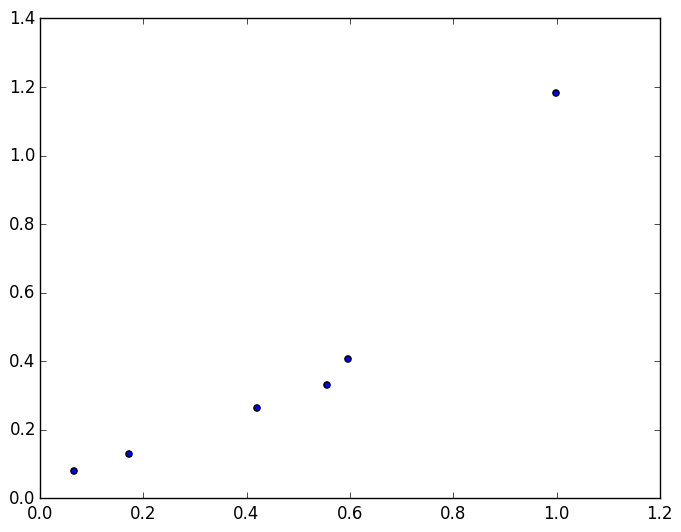

In [2]:
X = rand(6)' # six random input points
Y = X.^2 + 0.2 * rand(size(X))
scatter(X,Y);

Vandermonde matrix:
$$\Phi(x) = \left[\begin{matrix} 1 & x_1 & x_1^2 & \cdots & x_1^m \\ 1 & x_2 & x_2^2 & \cdots & x_2^m \\ & & \vdots \\ 1 & x_n & x_n^2 & \cdots & x_n^m \end{matrix}\right]$$

In [3]:
function vander(X, order)
    Phi = zeros(length(X), order + 1)
    for i = 1:length(X)
        Phi[i,:] = [X[i]^k for k = 0:order]
    end
    return Phi
end

vander (generic function with 1 method)

In [4]:
vander(X,3)

6x4 Array{Float64,2}:
 1.0  0.066098  0.00436895  0.000288779
 1.0  0.999172  0.998345    0.997519   
 1.0  0.171655  0.0294653   0.00505785 
 1.0  0.420418  0.176751    0.0743094  
 1.0  0.556684  0.309897    0.172515   
 1.0  0.596172  0.355421    0.211892   

$\hat f(x) = \hat w^\top \Phi(x)$  
$\hat w = \Phi^+(x) y$ (least-squares estimate)  
$\Phi^+ = (\Phi^\top \Phi)^{-1} \Phi^\top$ (Moore-Penrose pseudo-inverse)

In [5]:
function polyfit(X, y, order)
    w = pinv(vander(X, order)) * y'
    return x -> (w' * vander(x, order)')[1]
end    

polyfit (generic function with 1 method)

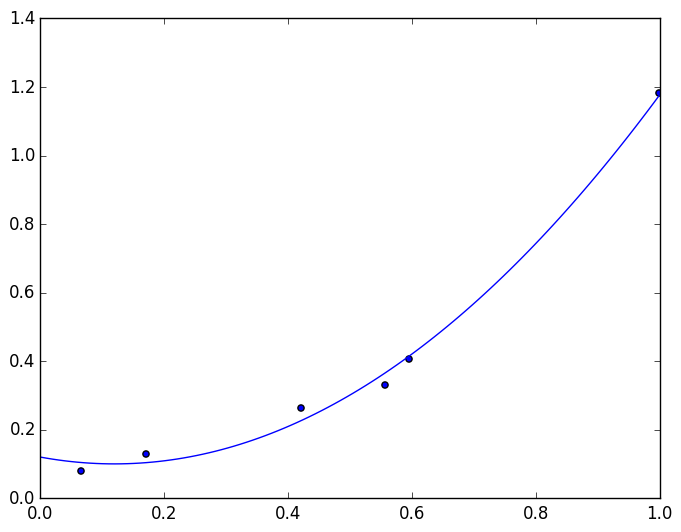

In [6]:
f = polyfit(X, Y, 2) # fit the data
scatter(X,Y)
xdom(0,1)
plot(f);

Slider{Int64}([Input{Int64}] 5,"order",5,1:9)

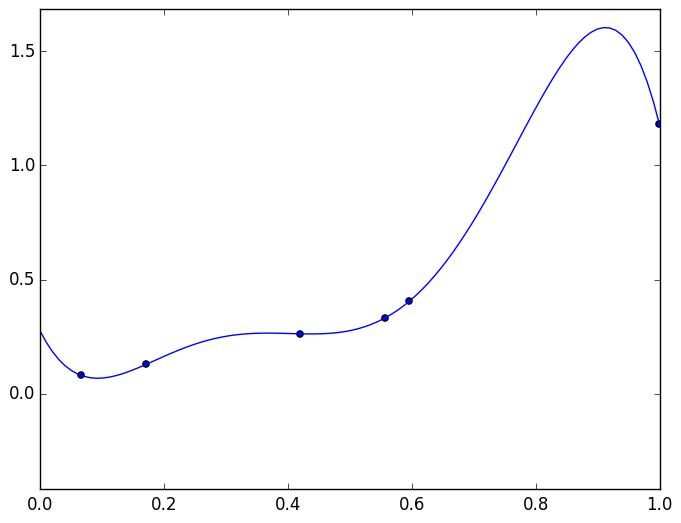

In [7]:
# try fits with different orders
fig = figure()
@manipulate for order = 1:9
    withfig(fig) do
        scatter(X,Y)
        f = polyfit(X,Y,order)
        plot(f)
        xlim(0,1)
        ylim(minimum(Y) - 0.5, maximum(Y) + 0.5)
    end    
end

In [8]:
# calculate the mean squared error (MSE) of f using test points X and target values y
function mse(f, X, y)
    n = size(X,2)
    mean([(f(X[:,i]) - y[i])^2 for i = 1:n])
end

mse (generic function with 1 method)

Slider{Int64}([Input{Int64}] 5,"order",5,1:9)

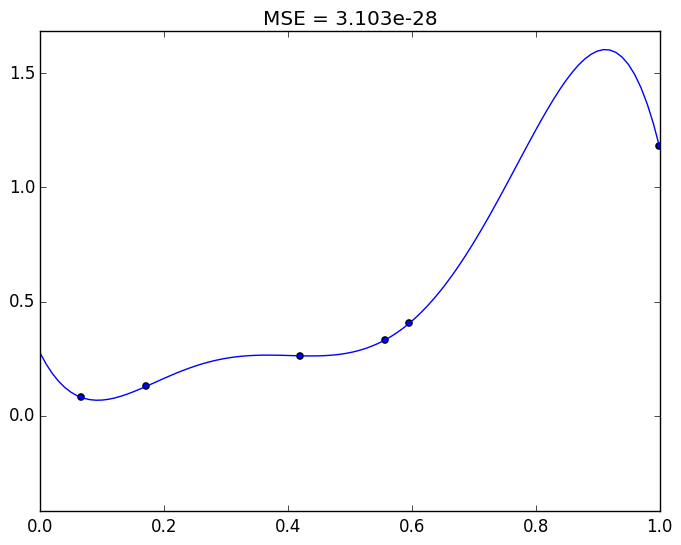

In [9]:
# compute MSE for various points
fig = figure()
@manipulate for order = 1:9
    withfig(fig) do
        scatter(X,Y)
        f = polyfit(X,Y,order)
        plot(f)
        xlim(0,1)
        ylim(minimum(Y) - 0.5, maximum(Y) + 0.5)
        title(@sprintf("MSE = %.3e", mse(f, X, Y)))
    end
end

How to pick the best order (and avoid overfitting)? Separate test set from training set.

# Cross Validation

In [10]:
type CVSet
    trainIndex
    testIndex
end

In [11]:
function cvSetHoldOut(n, holdOutProportion)
    perm = randperm(n)
    numTest = floor(holdOutProportion*n)
    testInd = 1:numTest
    trainInd = (numTest+1):n
    return [CVSet(perm[trainInd], perm[testInd])]
end

cvSetHoldOut (generic function with 1 method)

In [12]:
function cv(X, y, trainFunction, cvSets, lossFunction)
    loss = 0
    for i = 1:length(cvSets)
        cvSet = cvSets[i]
        # train
        Xtrain = X[:,cvSet.trainIndex]
        ytrain = y[cvSet.trainIndex]'
        f = trainFunction(Xtrain, ytrain)
        # test
        Xtest = X[:,cvSet.testIndex]
        ytest = y[cvSet.testIndex]'
        n = size(Xtest,2)
        for j = 1:n
            loss += lossFunction(f(Xtest[:,j]), ytest[j])
        end
    end
    return loss
end

cv (generic function with 1 method)

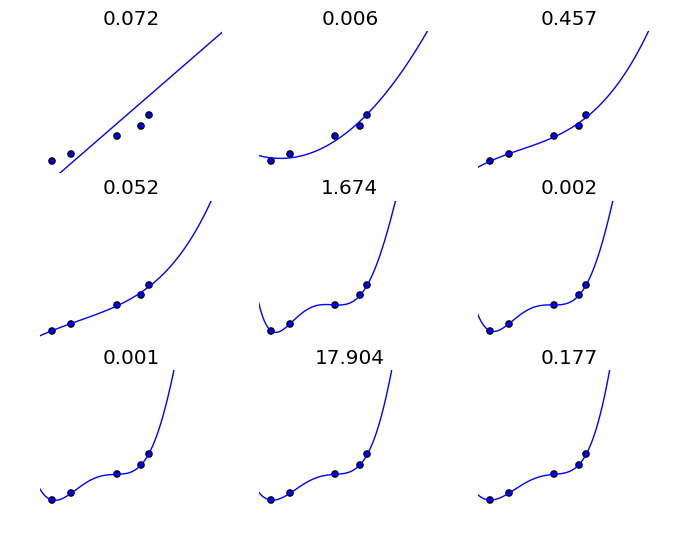

In [13]:
# metric
cvMetric(train) = cv(X, Y, train, cvSetHoldOut(size(X,2), 0.5), sqloss)
sqloss(x,y) = (x - y)^2

order = 9
numrow = 3
numcol = 3
for i = 1:order
    subplot(numrow, numcol, i)
    scatter(X,Y)
    train(x,y) = polyfit(x, y, i)
    f = train(X,Y)
    plot(f)
    axis("off")
    xlim(0,1)
    ylim(0,1)
    title(@sprintf("%.3f", cvMetric(train)))
end

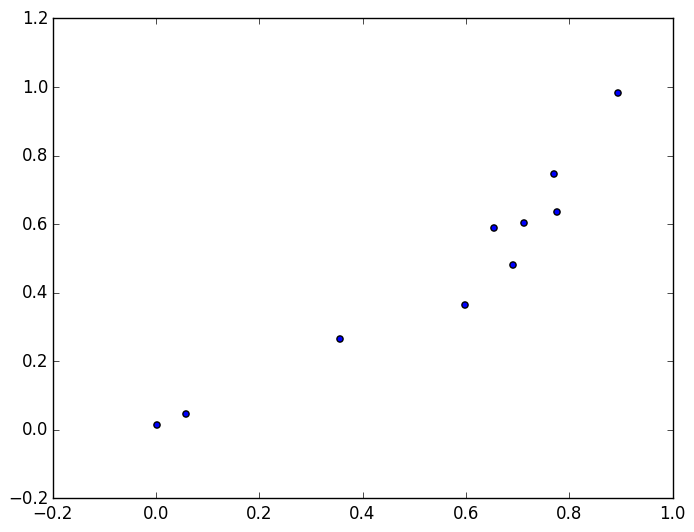

In [14]:
# let's make more samples
X = rand(10)'
Y = X.^2 + 0.2 * rand(size(X))
scatter(X,Y);

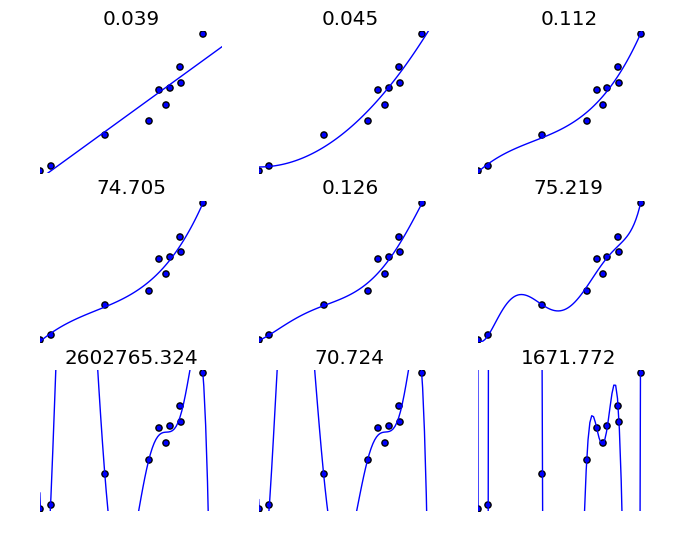

In [15]:
order = 9
numrow = 3
numcol = 3
for i = 1:order
    subplot(numrow, numcol, i)
    scatter(X,Y)
    train(x,y) = polyfit(x, y, i)
    f = train(X,Y)
    plot(f)
    axis("off")
    xlim(0,1)
    ylim(0,1)
    title(@sprintf("%.3f", cvMetric(train)))
end

In [16]:
function cvSetKFold(n, k)
    assert(k <= n)
    perm = randperm(n)
    sets = cell(k)
    for i = 1:k
        test = perm[i:k:n];
        train = perm[setdiff(1:n, i:k:n)]
        sets[i] = CVSet(train, test)
    end
    return sets
end

cvSetKFold (generic function with 1 method)

In [17]:
cvSetKFold(10,2)

2-element Array{Any,1}:
 CVSet([2,5,10,7,1],[3,8,4,6,9])
 CVSet([3,8,4,6,9],[2,5,10,7,1])

In [18]:
cvSetJackKnife(n) = cvSetKFold(n,n)
cvSetKFold(10,10)

10-element Array{Any,1}:
 CVSet([3,7,5,1,4,8,9,2,6],[10])
 CVSet([10,7,5,1,4,8,9,2,6],[3])
 CVSet([10,3,5,1,4,8,9,2,6],[7])
 CVSet([10,3,7,1,4,8,9,2,6],[5])
 CVSet([10,3,7,5,4,8,9,2,6],[1])
 CVSet([10,3,7,5,1,8,9,2,6],[4])
 CVSet([10,3,7,5,1,4,9,2,6],[8])
 CVSet([10,3,7,5,1,4,8,2,6],[9])
 CVSet([10,3,7,5,1,4,8,9,6],[2])
 CVSet([10,3,7,5,1,4,8,9,2],[6])

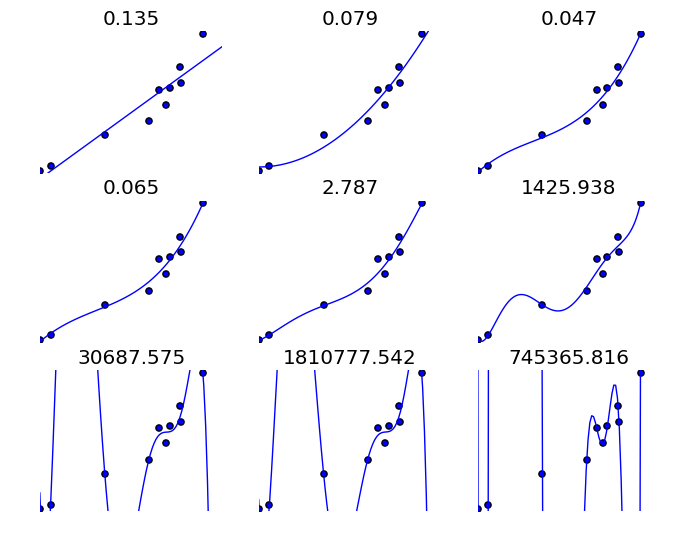

In [19]:
# metric
cvMetric(train) = cv(X, Y, train, cvSetJackKnife(size(X,2)), sqloss)

order = 9
numrow = 3
numcol = 3
for i = 1:order
    subplot(numrow, numcol, i)
    scatter(X,Y)
    train(x,y) = polyfit(x, y, i)
    f = train(X,Y)
    plot(f)
    axis("off")
    xlim(0,1)
    ylim(0,1)
    title(@sprintf("%.3f", cvMetric(train)))
end

# Radial Basis Functions

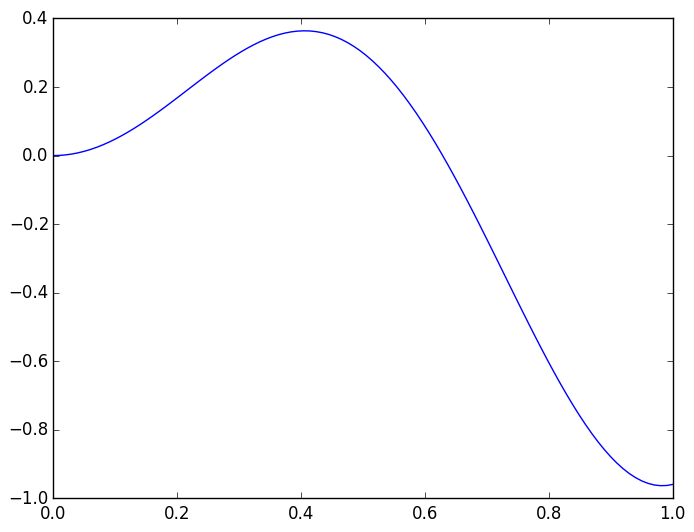

In [20]:
# true function
f = x -> x .* sin(5 .* x)
xdom(0,1)
plot(f);

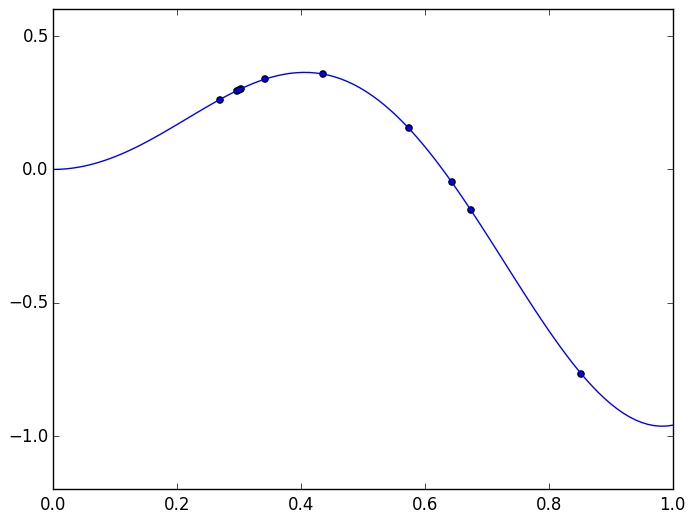

In [21]:
# Let's add some random samples from this function as the training data
X = rand(10)'
Y = f(X)
xdom(0,1)
plot(f)
scatter(X,Y);

Gram matrix $\Psi_{ij} = \psi(||x^{(i)} - x^{(j)}||)$

In [22]:
function gram(X, basisFunction)
    n = size(X,2)
    G = zeros(n,n)
    for i = 1:n
        for j = 1:n
            G[i,j] = basisFunction(norm(X[:,i] - X[:,j]))
        end
    end
    return G
end

gram (generic function with 1 method)

In [23]:
basisFunction = r->exp(-10*r^2)
gram(X, basisFunction)

10x10 Array{Float64,2}:
 1.0        0.999526   0.822914  0.999872   …  0.979313   0.299037  0.239855
 0.999526   1.0        0.838488  0.999891      0.985031   0.313542  0.252544
 0.822914   0.838488   1.0       0.831075      0.915625   0.649231  0.566884
 0.999872   0.999891   0.831075  1.0           0.982399   0.306531  0.246402
 0.99263    0.988451   0.757115  0.990572      0.948218   0.245716  0.193854
 0.0452872  0.0488692  0.176163  0.0471216  …  0.0737597  0.646481  0.727277
 0.461589   0.479376   0.825602  0.470811      0.582902   0.952974  0.905183
 0.979313   0.985031   0.915625  0.982399      1.0        0.402371  0.331837
 0.299037   0.313542   0.649231  0.306531      0.402371   1.0       0.990797
 0.239855   0.252544   0.566884  0.246402      0.331837   0.990797  1.0     

In [24]:
w = pinv(gram(X, basisFunction))*Y'

10x1 Array{Float64,2}:
  -34.6927 
  -20.4244 
  -45.6609 
  -28.0664 
   29.9454 
   -4.18165
   72.53   
   80.1585 
 -142.505  
   92.3041 

In [25]:
function radialBasisInterpolation(X, y, basisFunction)
    w = pinv(gram(X, basisFunction)) * y'
    return x -> (w'*Float64[basisFunction(norm(x - X[:,i])) for i = 1:size(X,2)])[1]
end

radialBasisInterpolation (generic function with 1 method)

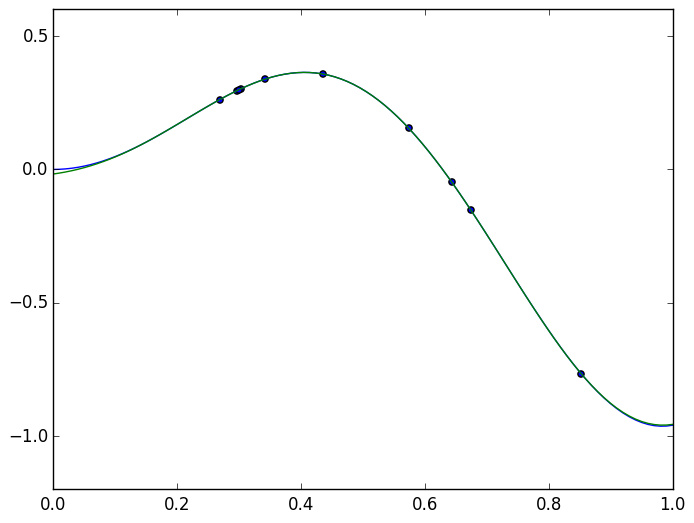

In [26]:
xdom(0,1)
plot(f)
scatter(X,Y)
plot(radialBasisInterpolation(X, Y, basisFunction));

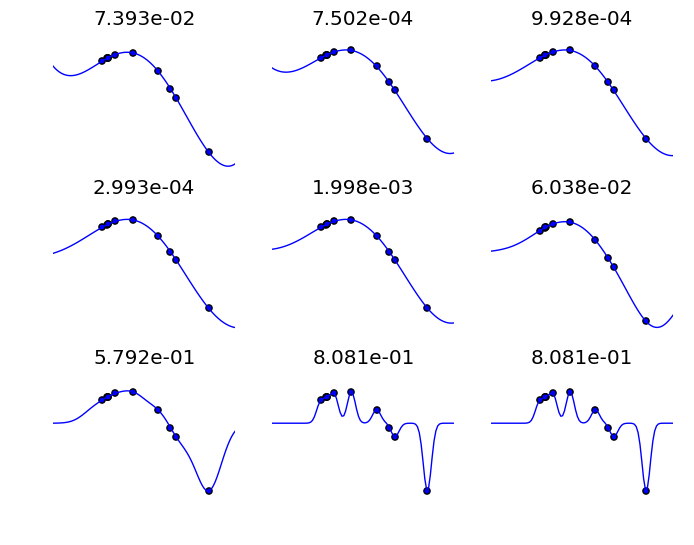

In [27]:
cvMetric(train) = cv(X, Y, train, cvSetJackKnife(size(X,2)), sqloss)
scale = [0.5 1 2 3 10 20 100 1000 1000 10000]
for j = 1:order
    subplot(numrow, numcol, j)
    scatter(X,Y)
    basisFunction = r->exp(-scale[j]*r^2)
    train(x,y) = radialBasisInterpolation(x, y, basisFunction)
    f = train(X,Y)
    plot(f)
    axis("off")
    #xlim(0,1)
    #ylim(0,1)
    title(@sprintf("%.3e", cvMetric(train)))
end

# Accomodating Noise

$w = (\Phi + \lambda I)^+ y$ using regularization parameter $\lambda$ (should be set to the variance of the noise)

In [28]:
function radialBasisInterpolation(X, y, basisFunction, regularizationParameter)
    n = length(y)
    w = pinv(gram(X, basisFunction) + regularizationParameter * eye(n)) * y'
    return x -> (w'*Float64[basisFunction(norm(x - X[:,i])) for i = 1:size(X,2)])[1]
end;

Slider{Float64}([Input{Float64}] 0.04,"regularizationParameter",0.04,0.0:0.02:0.1)

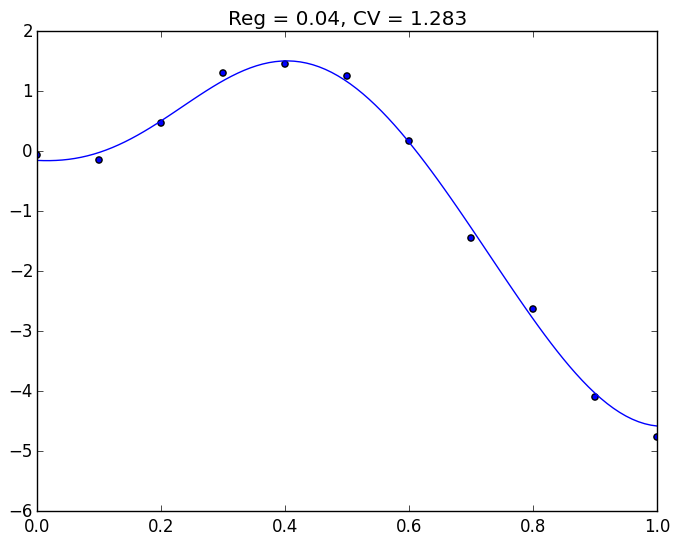

In [29]:
X = linspace(0,1,11)'
Y = 5 * X .* sin(5 .* X) .+ 0.3 * randn(11)'
basisFunction = r->exp(-10*r^2)
cvMetric(train) = cv(X, Y, train, cvSetJackKnife(size(X,2)), sqloss)
fig = figure()
@manipulate for regularizationParameter = 0:0.02:0.1
    withfig(fig) do
        scatter(X,Y)
        mytrain(x,y) = radialBasisInterpolation(x, y, basisFunction, regularizationParameter)
        f = mytrain(X,Y)
        plot(f)
        title(@sprintf("Reg = %.2f, CV = %.3f", regularizationParameter, cvMetric(mytrain)))
    end
end